In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_10 import *

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Mixup

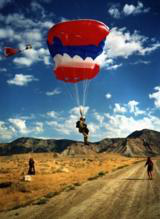

In [6]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

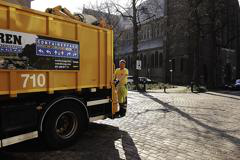

In [7]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

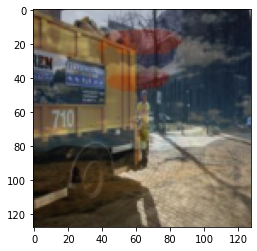

In [8]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

# Implementation

In [9]:
Γ = lambda x: x.lgamma().exp()

In [10]:
facts = [math.factorial(i) for i in range(7)]

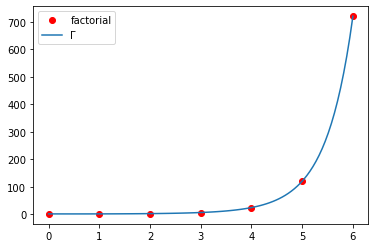

In [13]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial', 'Γ']);

In [12]:
torch.linspace(0, 0.9, 10)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In [26]:
Γ(torch.tensor(0.1)), Γ(torch.tensor(0.8))

(tensor(9.5135), tensor(1.1642))

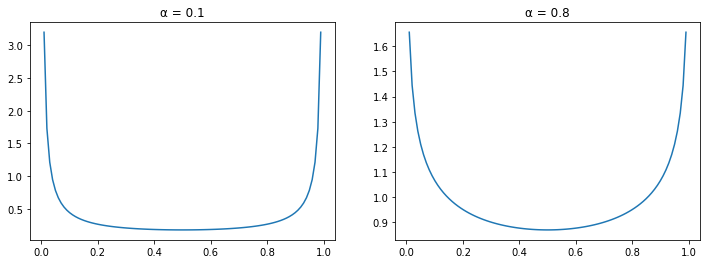

In [29]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0, 1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f'α = {α:.1}')

In [30]:
#export
class NoneReduce():
    def __init__(self, loss_func):
        self.loss_func, self.old_red = loss_func, None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else:
            return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [33]:
#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [41]:
#export
class MixUp(Callback):
    _order = 90
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func, self.run.loss_func = self.run.loss_func, self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1, self.yb1 = self.xb[shuffle], self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self):
        self.run.loss_func = self.old_loss_func
        
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [42]:
nfs = [32,64,128,256,512]

In [43]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy, cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, opt_func, lr, cb_funcs=cb_funcs)

In [44]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, ProgressCallback,
       partial(BatchTransformXCallback, norm_imagenette),
       MixUp]

In [45]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [46]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.138356,0.204985,2.304608,0.228535,00:10


# LabelSmoothing

In [51]:
#export
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [52]:
learn = get_learner(nfs, data, 0.4, conv_layer, loss_func=LabelSmoothingCrossEntropy(), cb_funcs=cbfs[:-1])

In [53]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.119337,0.245221,3.076189,0.171720,00:08


In [55]:
assert learn.loss_func.reduction == 'mean'

In [1]:
!python notebook2script.py 10b_mixup_label_smoothing.ipynb

Converted 10b_mixup_label_smoothing.ipynb to exp/nb_10b.py
